In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
#from __future__ import print_function

## 2.2.2 Example: Bayesian A/B Testing

A/B testing is a statistical design pattern for determining the difference of effectiveness between two different treatments. For example, a pharmaceutical company is interested in the effectiveness of drug A versus drug B. The company will test drug A on some percentage of a patient group, and drug B on the rest (this split is often 50-50, but we will relax this assumption). After performing enough trials, the in-house statisticians measure the effectiveness to determine which drug yielded results.

Similarly, front-end Web developers are interested in which design of their Web site yields more _conversions_, where a conversion could be a visitor signing up, purchasing something, or taking some other action. They will route some fraction of visitors to site A, and the other fraction to site B (which has an alternate design), and record if the visit yielded a conversion or not. The assignments and conversions are recorded and analyzed afterward.

The key value of A/B tests is that there is only a single difference between groups. Thus, any significant change in the metrics (like drug effectiveness or conversions) can be directly attributed to the difference.

Often, the post-experiment analysis is done using something called a "hypothesis test" ike a _difference of means test_ or _difference of proportions test_. This involves often misunderstood quantities like a "Z-score" and even more confusing "p-values" (please don't ask). If you have taken a statistics course, you have probably been taught this technique (although not necessarily _learned_ this technique). And if you were like me, you may have felt uncomfortable with their derivatoin. If so, good. The Bayesian approach to this problem is more natural.



## 2.2.3 A Simple Case

As this is a _hacker_ book, we'll continue with the web-development example. For the moment, we will focus on the analysis of site A first. Assume that there is some probability, $p_A$, that users who are shown site A eventually convert. This is the true effectiveness of site A. Currently, this quantity is unknown to us.

Suppose site A was shown to $N$ people, and $n$ people converted. One might conlcude hastily that $p_A = \frac{n}{N}$.
Unfortunately, the _observed frequency_ $\frac{n}{N}$ does not necessarily equal $p_A$; there is a difference between the _observed frequency_ and the _true frequency_ of an event. The true frequency can be interpreted as the probability of an event occurring, and this does not necessarily equal the observed frequency. For example, the true frequency of rolling a 1 on a six-sided die is $\frac{1}{6}$, but if we roll the dice six times we may not see a 1 show up at all (the observed frequency)! We must commonly determine the true frequency of events like:

* The fraction of users who make purchases
* The proportion of some characteristic in a population
* The percentage of Internet users with cats
* Or the probability that it will rain tomorrow

Unfortunately, noise and complexities hide the true frequency from us and we must _infer_ it from observed data. We use Bayesian statistics to infer probable values of the true frequency using an apprpriate prior and observed data. With respect to our conversion example, we are interested in using what we know, $N$ (the total visitors) and $n$ (the number of conversions), to estimate what $p_A$, the true frequency of conversion, might be.

To set up a Bayesian model, we need to assign prior distributions to our unknown quantities. _A priori_, what do you think $p_A$ might be? For this example, we have no strong conviction about $p_A$, so for now, let's assume $p_A$ is uniform over [0,1]:

In [2]:
import pymc as pm

# The parameters are bounds of the Uniform
p = pm.Uniform('p', lower=0, upper=1)

For this example, suppose $p_A = 0.05$, and $N = 1500$ users shown site A, and we will simulate whether the user made a purchase or not. To simulate this from N trials, we will use a **Bernoulli distribution**. A Bernoulli distribution is a binary random variable (0 or 1 only), and as our observations are binary (not convert or convert), it is appropriate here. More formally, if 
$X \sim \mbox{Ber}(p)$, then $X$ is 1 with probability $p$ and 0 with probability $1-p$. 
Of course, in practice we do not know $p_A$, but we will use it here to simulate artificial data.

In [4]:
# set constants
p_true = 0.05 # remember, this is unknown in real life
N = 1500

# Sample N Bernoulli random variables from Ber(0.05)
# Each random variable has a 0.05 chance of being a 1
# This is the data-generation step

occurrences = pm.rbernoulli(p_true, N)

print occurrences
# Remeber: Python treats True == 1, and False == 0
print occurences.sum()

[False False False ..., False False False]
60


In [5]:
# Occurrences.mean() is equal to n/N

print "What is the observed frequency in Group A? %.4f " % occurences.mean()

What is the observed frequency in Group A? 0.0400 


In [6]:
# Include the observatoins, which are Bernoulli

obs = pm.Bernoulli("obs", p, value=occurrences, observed = True)

mcmc = pm.MCMC([p, obs])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 0.8 sec

C:\Users\ddooling\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


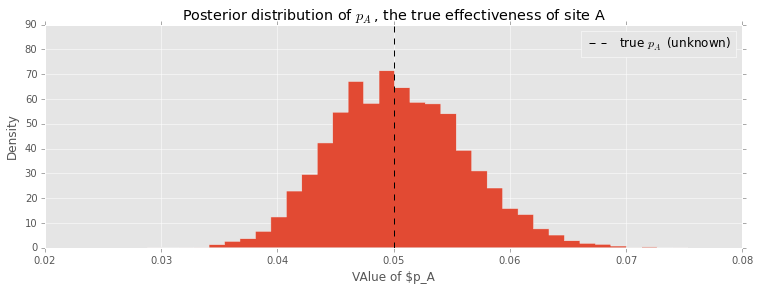

In [8]:
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plot

figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--",
          label="true $p_A$ (unknown)")
plt.hist(mcmc.trace("p")[:], bins=35, histtype="stepfilled", normed=True)
plt.xlabel("VAlue of $p_A")
plt.ylabel("Density")
plt.legend()